### test
用基础算子测试block

In [1]:
item = 'block_3'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
cm = 1/2.54

import scipy.io as scio
import torch
import torch.nn as nn
from torchinfo import summary
from timeit import default_timer
import sys
sys.path.append("../scripts/")
sys.path.append("../run/")
import yaml
from utilities import *
from deeponet_2d import *
# from fourier_2d import *
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [ ]:
plt.rcParams['font.family']       = 'arial' # 'Times New Roman' #
# plt.rcParams['axes.linewidth']    = 1
plt.rcParams['xtick.major.size']  = 2.
plt.rcParams['ytick.major.size']  = 2.5
plt.rcParams['xtick.minor.size']  = 1.5
plt.rcParams['ytick.minor.size']  = 1.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['lines.linewidth']   = 1.5
plt.rcParams['lines.markersize']  = 3.5

plt.rcParams['font.size']    = 10
# plt.rcParams['figure.titlesize'] = 2

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize']  = 7 # x, y label size
plt.rcParams['axes.titlesize'] = 7 # font size of the axes title
# plt.rcParams['legend.fontsize'] = 8
# plt.rcParams['legend.title_fontsize'] = 8

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams['image.cmap'] = 'jet_r'
plt.rcParams['figure.dpi'] = 150

In [ ]:
with open( '../run/config.yml') as f:
    config = yaml.full_load(f)
config = config[item]
device = torch.device('cpu')
TRAIN_PATH = config['TRAIN_PATH']
TEST_PATH  = config['TEST_PATH']
save_mode  = config['save_mode']
n_out      = config['n_out'] # rhoxy,phsxy,rhoyx,phsyx
model_path = "../model/"+config['name']+ "_"+str(n_out) # save path and name of model
model_path_temp = "../temp/"+config['name']+"_"+ str(n_out)
log_path = "../Log/"+config['name']+"_"+str(n_out)+'.log'

ntrain = config['ntrain']
ntest  = config['ntest']

batch_size = config['batch_size']
learning_rate = config['learning_rate']

epochs = config['epochs']
step_size = config['step_size']
gamma = config['gamma']

modes = config['modes']
width = config['width']

s_train = config['s_train']
r_train = config['r_train']
s_test = config['s_test']
r_test = config['r_test']
layer_num = config['layer_num']
last_size = config['last_size'] 
act_fno   = config['act_fno']

layer_sizes = config['layer_sizes']+[s_train[0]*s_train[1]]
act_func  = config['act_func']
init_func = config['init_func']
    

patience = config['patience'] # if there is {patience} epoch that val_error is larger, early stop,
thre_epoch = config['thre_epoch']# condiser early stop after {thre_epoch} epochs

print_model_flag = config['print_model_flag'] # 

In [5]:
if os.path.exists(model_path+'.pt'):
    model=torch.load(model_path+'.pt',map_location=device)
elif os.path.exists(model_path+'.pkl'):
    model=deeponet(layer_sizes, act_func, init_func,modes, modes, width,\
        n_out,layer_num, last_size, act_fno).to(device)
    model.load_state_dict(torch.load(model_path+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')
myloss = LpLoss(size_average=False)

In [6]:
loc_train,loc_test,train_loader, test_loader, x_normalizer,y_normalizer = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]

begin to read data
reading finished in 1.959 s


In [7]:
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        out = model(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y.shape[-1]
        out = torch.cat(([out[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out = y_normalizer.decode(out)

        test_l2 += myloss(out, y).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

6.297603948041797 0.02304957675933838


### 基础算子

In [8]:
model_path =  "../model/random_10_64"+ "_3_"+str(n_out)
if os.path.exists(model_path+'.pt'):
    model_base=torch.load(model_path+'.pt',map_location=device)
elif os.path.exists(model_path+'.pkl'):
    model_base=deeponet(layer_sizes, act_func, init_func,modes, modes, width,\
        n_out,layer_num, last_size, act_fno).to(device)
    model_base.load_state_dict(torch.load(model_path+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')
myloss = LpLoss(size_average=False)

In [9]:
model_base.eval()
model_base.to(device)
y_normalizer.to(device)
test_l2 = 0.0
sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        out_base = model_base(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y.shape[-1]
        out_base = torch.cat(([out_base[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out_base = y_normalizer.decode(out_base)

        test_l2 += myloss(out_base, y).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

6.117058650590479 0.02426631808280945


In [10]:
# xy mode
model_base.eval()
model_base.to(device)
y_normalizer.to(device)
test_l2 = 0.0
sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        out_base = model_base(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y.shape[-1]
        out_base = torch.cat(([out_base[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out_base = y_normalizer.decode(out_base)

        test_l2 += myloss(out_base[...,:2], y[...,:2]).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

5.59154542721808 0.043221234798431395


In [10]:
model_base.eval()
model_base.to(device)
y_normalizer.to(device)
test_l2 = 0.0
sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        out_base = model_base(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y.shape[-1]
        out_base = torch.cat(([out_base[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out_base = y_normalizer.decode(out_base)

        test_l2 += myloss(out_base[...,2:], y[...,2:]).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

6.21630181837827 0.019639851450920107


In [11]:
def error_r(x1,x0):
    '''relative error 
    x1 : prediction
    x0 : exact
    '''
    return np.linalg.norm(x1-x0)/np.linalg.norm(x0)

Relative rhoxy,rhoyx, phsxy,phsyx error:  0.025783023 0.051967073 0.04491151 0.057301804
Relative base rhoxy,rhoyx, phsxy,phsyx error:  0.05218464 0.059131518 0.03516391 0.055714592


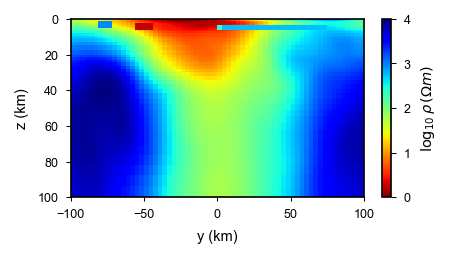

In [12]:
rho_id = 16 # 3,6, 12

n_bins = 5 # number of ticks in colorbar
a_cof = x_normalizer.decode(x)[rho_id, ..., 0].cpu().numpy()
a_cof = np.log10(1/(10**a_cof))
rhoxy = out[rho_id, ...,0].cpu().numpy()
phsxy = -1*out[rho_id, ...,1].cpu().numpy()
rhoyx = out[rho_id, ...,2].cpu().numpy()
phsyx = -1*out[rho_id, ...,3].cpu().numpy()+180
rhoxy_base = out_base[rho_id, ...,0].cpu().numpy()
phsxy_base = -1*out_base[rho_id, ...,1].cpu().numpy()
rhoyx_base = out_base[rho_id, ...,2].cpu().numpy()
phsyx_base = -1*out_base[rho_id, ...,3].cpu().numpy()+180
rhoxy_true = y[rho_id, ...,0].cpu().numpy()
phsxy_true = -1*y[rho_id, ...,1].cpu().numpy()
rhoyx_true = y[rho_id, ...,2].cpu().numpy()
phsyx_true = -1*y[rho_id, ...,3].cpu().numpy()+180

print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy,rhoxy_true),error_r(rhoyx,rhoyx_true),error_r(phsxy,phsxy_true),error_r(phsyx,phsyx_true),)
print("Relative base rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy_base,rhoxy_true),error_r(rhoyx_base,rhoyx_true),error_r(phsxy_base,phsxy_true),error_r(phsyx_base,phsyx_true),)
# print("Relative rhoxy_100,rhoyx_100, phsx_100y,phsyx_100  error: ", \
#      error_r(rhoxy_100,rhoxy_true),error_r(rhoyx_100,rhoyx_true),error_r(phsyx_100,phsyx_true),error_r(phsyx_100,phsyx_true),)
# print("Relative rhoxy_25,rhoyx_25, phsx_25y,phsyx_25  error: ", \
#      error_r(rhoxy_25,rhoxy_true),error_r(rhoyx_25,rhoyx_true),error_r(phsyx_25,phsyx_true),error_r(phsyx_25,phsyx_true),)
fig = plt.figure(figsize=(8*cm,4*cm))
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn/1e3,zn/1e3,a_cof, vmin=0,vmax=4,shading='flat')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\log_{10}\,\rho\,(\Omega m)$")# ax = plt.subplot(3,2,2)
cbar.ax.locator_params(nbins=n_bins)
# h=ax.pcolormesh(yn/1e3,zn/1e3,x_train0[i,...], shading='flat')
# ax.invert_yaxis()
# fig.colorbar(h)
# ax.set_aspect(1)
# plt.savefig("../imags/block_resisitivety_r"+str(rho_id)+".pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()


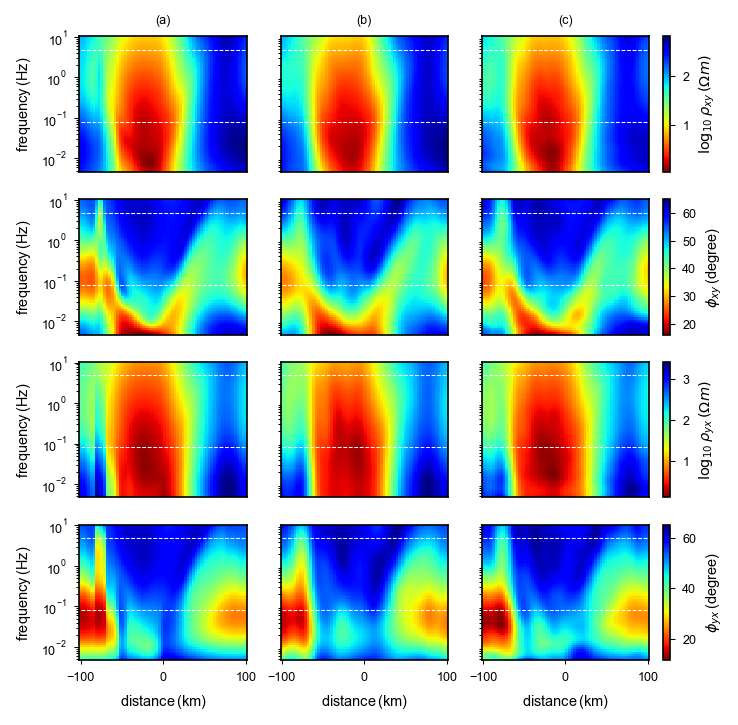

In [13]:
f_id1 = 6# idx of frequency
f_id2 = 40# idx of frequency

pad            = 0.02 # pad between colorbar and map (value is relative to figsize?)   
text_size      = 7 # text size
bar_size       = 7 # label size of colorbar
linewidth      = 0.5
# for line style
color          = 'white'
linestyle      = 'dashed'
color_f        = 'black'
linestyle_f    = 'solid'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'right' # colorbar location relative to map
text_x_pos     = -135 # text location (value is relative to axis data in map)
text_y_pos     = 18.0 
rotation       = 0  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.

plt.rcParams['axes.titlesize'] = 6 # font size of the axes title
title_out = ['(a)','(b)','(c)']
bar_label = [r'$\log_{10}\,\rho_{xy}\,(\Omega m)$',r'$\phi_{xy}\,$(degree)',\
             r'$\log_{10}\,\rho_{yx}\,(\Omega m)$',r'$\phi_{yx}\,$(degree)']
x_label   = r'distance$\,$(km)'
y_label   = r'frequency$\,$(Hz)'

data = [[rhoxy_true,rhoxy,rhoxy_base],
        [phsxy_true,phsxy,phsxy_base],
        [rhoyx_true,rhoyx,rhoyx_base],
        [phsyx_true,phsyx,phsyx_base]
        ]

norm_rhoxy = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]

ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_column1 = [freq[f_id1],freq[f_id1]]
freq_column2 = [freq[f_id2],freq[f_id2]]

n_row,n_column = 4,3
figsize   = (5*n_column*cm,3.5*n_row*cm)

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        h = ax[i,j].pcolormesh(ry/1e3,freq,data[i][j],norm=norm[i], shading=shading)
        ax[i,j].plot(ry_column,freq_column1,color = color,linestyle=linestyle,linewidth=linewidth)
        ax[i,j].plot(ry_column,freq_column2,color = color,linestyle=linestyle,linewidth=linewidth)
        ax[i,j].set_yscale("log")
        
        

        if i == 0:
            ax[i,j].set_title(title_out[j])
#             text(text_x_pos,text_y_pos,title_out[j], horizontalalignment='center',\
#                          verticalalignment='center',rotation=rotation,fontsize=text_size)
        if i!=n_row-1:
            ax[i,j].set_xticks([])
            
        if j == 0:
            ax[i,j].yaxis.tick_left()
            ax[i,j].yaxis.set_label_position("left")
            ax[i,j].set_ylabel(y_label)
        else:
            ax[i,j].set_yticks([])
        
        if j == n_column-1:
            cbar = fig.colorbar(h,ax=[ax[i,jj] for jj in range(n_column)],location=loc,pad=pad)
            cbar.set_label(bar_label[i],fontsize=bar_size)#,labelpad=labelpad)
            cbar.ax.xaxis.set_ticks_position(ticks_position)
            
    ax[i,j].set_xlabel(x_label)
#         if j!=0 or i!=0:
#             ax[i,j].set_xticks([])
#             ax[i,j].set_yticks([])
# plt.subplots_adjust(wspace=0.1)
# fig.tight_layout()
# plt.savefig("../imags/block_r"+str(rho_id)+"_o"+str(obs_id)+"_f"+str(f_id)+".jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/block_compare.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/block_compare.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)

plt.show()

frequency is: 4.84859814381753 Hz
frequency is: 0.08018773366816309 Hz



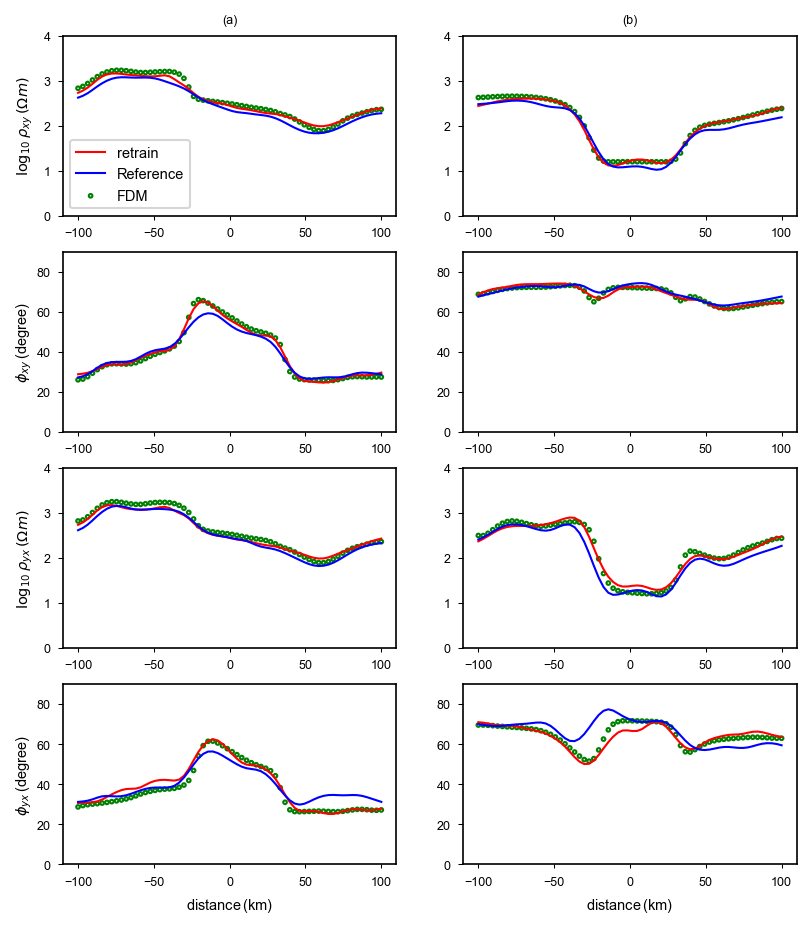

In [15]:

plt.rcParams['legend.fontsize']        = 7
plt.rcParams['axes.labelsize']         = 7

title_out = ['(a)','(b)','(c)']
title_label = ['FDM','retrain','Reference']

n_row,n_column = 4,2
figsize   = (7*n_column*cm,4*n_row*cm)
linewidth =1
text_x_pos     = -140 # text location (value is relative to axis data in map)
text_x_pos1     = 40 # text location (value is relative to axis data in map)
text_y_pos     = 4.2 

y_label = [r'$\log_{10}\,\rho_{xy}\,(\Omega m)$',\
           r"$\phi_{xy}\,$(degree)",\
           r'$\log_{10}\,\rho_{yx}\,(\Omega m)$',\
           r"$\phi_{yx}\,$(degree)"]
x_label = [r"distance$\,$(km)",r"distance$\,$(km)",]
title   = ['xy mode','yx mode']



# rho_min = np.min([rhoxy_x_true,rhoxy_x,rhoyx_x_true,rhoyx_x])
# rho_max = np.max([rhoxy_x_true,rhoxy_x,rhoyx_x_true,rhoyx_x])
# phs_min = np.min([phsxy_x_true,phsxy_x,phsyx_x_true,phsyx_x])
# phs_max = np.max([phsxy_x_true,phsxy_x,phsyx_x_true,phsyx_x])
# rho_lim = [rho_min,rho_max]
# phs_lim = [phs_min,phs_max]
rho_ticks  = [0.0,1.0,2.0,3.0,4.0]
rho_lim = [0,4.0]
phs_lim = [0,90]

print(f"frequency is: {freq[f_id1]} Hz")
print(f"frequency is: {freq[f_id2]} Hz")
print("")

data0   = [[rhoxy_true[f_id1,:],   phsxy_true[f_id1,:],  rhoyx_true[f_id1,:],  phsyx_true[f_id1,:]],
           [rhoxy_true[f_id2,:],   phsxy_true[f_id2,:],  rhoyx_true[f_id2,:],  phsyx_true[f_id2,:]]]
data1   = [[rhoxy[f_id1,:],  phsxy[f_id1,:],  rhoyx[f_id1,:],  phsyx[f_id1,:]],
           [rhoxy[f_id2,:],  phsxy[f_id2,:],  rhoyx[f_id2,:],  phsyx[f_id2,:]]]
data2   = [[rhoxy_base[f_id1,:],  phsxy_base[f_id1,:],  rhoyx_base[f_id1,:],  phsyx_base[f_id1,:]],
           [rhoxy_base[f_id2,:],  phsxy_base[f_id2,:],  rhoyx_base[f_id2,:],  phsyx_base[f_id2,:]]]


fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        if j == 0:
            ax[i,j].scatter(ry/1e3, data0[j][i],color='None',marker='o',s=3,edgecolors='g',             label=title_label[0])     
            ax[i,j].plot(   ry/1e3, data1[j][i],color='r', linewidth=linewidth,linestyle='solid', marker='None',markersize=1,label=title_label[1])
            ax[i,j].plot(   ry/1e3, data2[j][i],color='b', linewidth=linewidth,linestyle='solid', marker='None',markersize=1,label=title_label[2])            
            if i%2==0:
                ax[i,j].set_ylabel(y_label[i])
            else:
                ax[i,j].set_ylabel(y_label[i],labelpad=1)


#         ax[i,jj].plot(   freq, data2[i][j],color='b', linestyle='solid', marker='None',markersize=1,label=title_label[2])
        elif j==1:
            ax[i,j].scatter(ry/1e3, data0[j][i],color='None',marker='o',s=3,edgecolors='g',             label=title_label[0])     
            ax[i,j].plot(   ry/1e3, data1[j][i],color='r', linewidth=linewidth,linestyle='solid', marker='None',markersize=1,label=title_label[1])
            ax[i,j].plot(   ry/1e3, data2[j][i],color='b', linewidth=linewidth,linestyle='solid', marker='None',markersize=1,label=title_label[2])            
#             ax[i,j].invert_xaxis()
#             ax[i,j].set_xscale("log")       
        
#         ax[i,j].tick_params(axis='both',which='major',length=2, width=1,direction='in')
#         ax[i,j].tick_params(axis='both',which='minor',length=1, width=1,direction='in')
        
                
        if i == 0:
            ax[i,j].set_title(title_out[j])
#             (text_x_pos1,text_y_pos,title_out[j], horizontalalignment='center',\
#                                      verticalalignment='center',rotation=rotation,fontsize=text_size)            
            ax[i,j].set_ylim(rho_lim)
            ax[i,j].set_yticks(rho_ticks)
#             ax[i,j].set_title(title[0])
            
#             ax[i,j].set_aspect(1) # same scale
#             ax[i,j].legend()
        elif i == 1:
            ax[i,j].set_ylim(phs_lim)
        elif i == 2:
            ax[i,j].set_ylim(rho_lim)
            ax[i,j].set_yticks(rho_ticks)
#             ax[i,j].set_title(title[1])
        elif i == 3:
            ax[i,j].set_xlabel(x_label[j])           
            ax[i,j].set_ylim(phs_lim)
            
ax[0,0].legend(loc='lower left')
fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0.2, hspace =0.2)#调整子图间距
plt.savefig("../imags/block_freq.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.savefig("../imags/block_freq.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()            

In [16]:
1/freq[-1]

200.00000000000003